<ipython-input-5-f4c8f6777ccf>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x,


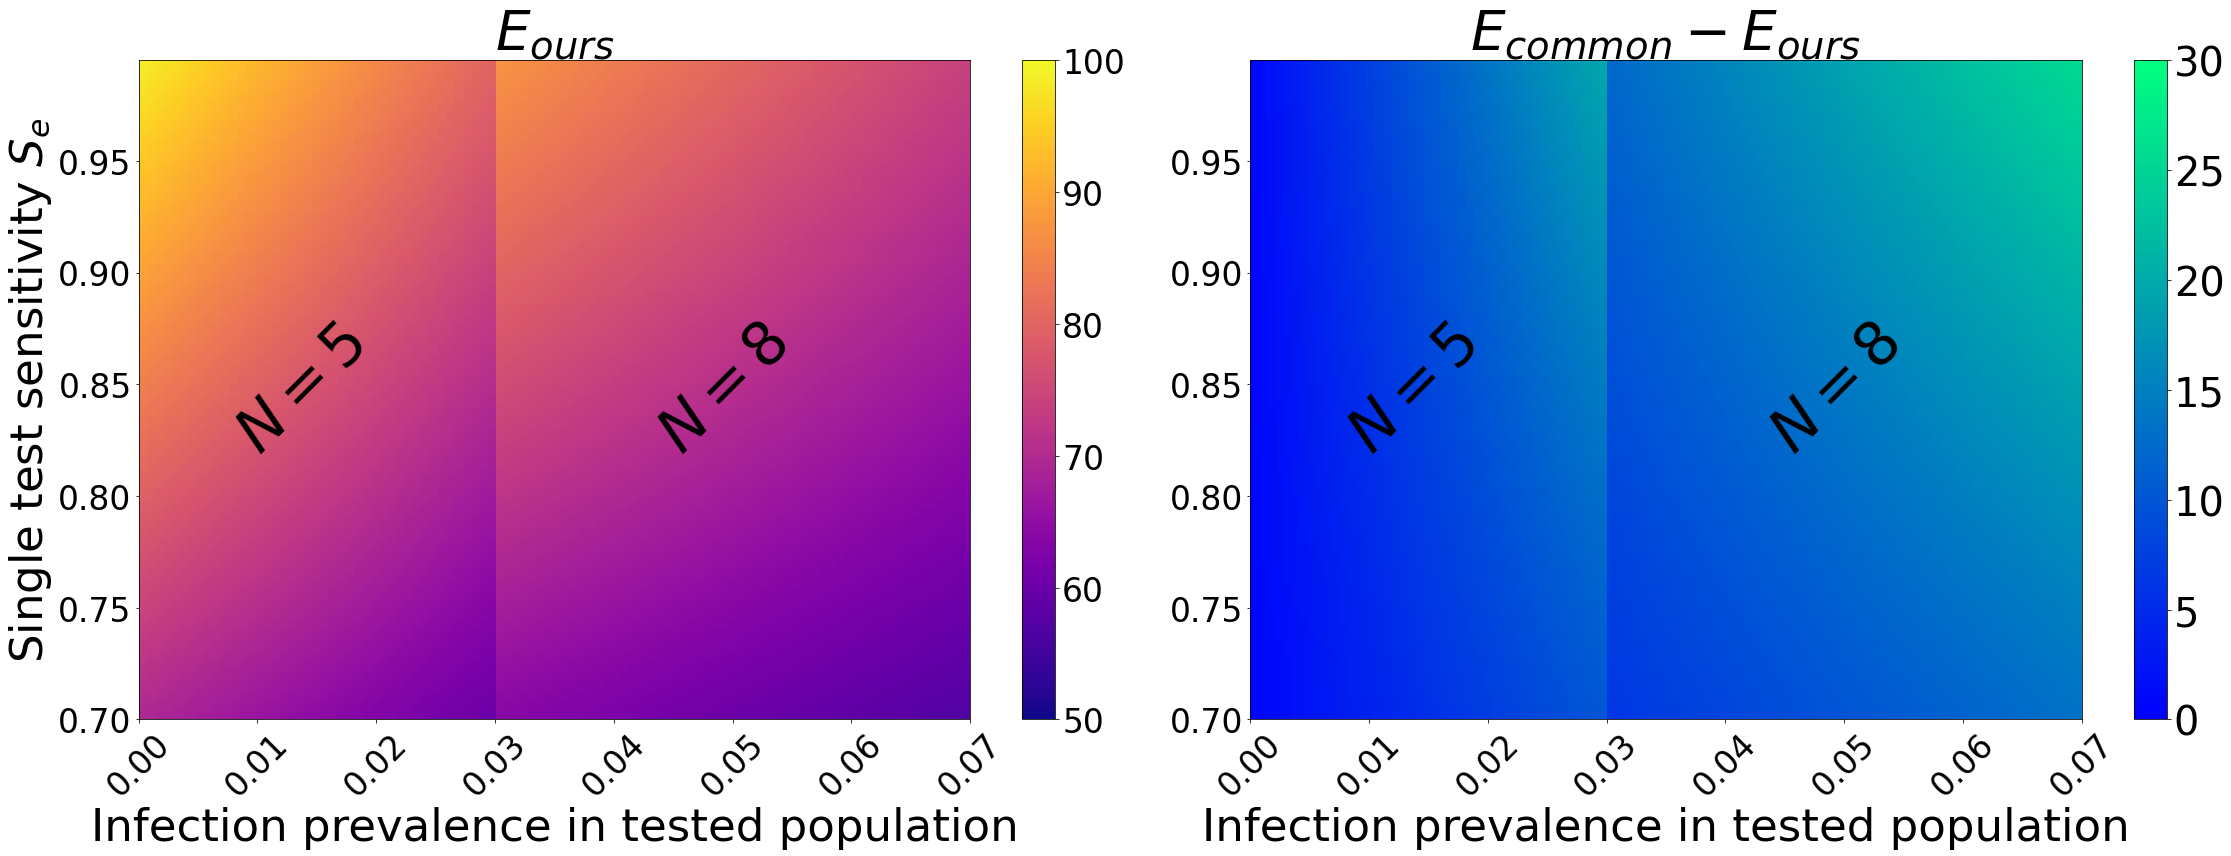

In [5]:
def f(tp, q, fp, model='ours'):
    #S = (-75*q + 9.5).astype(int)
    S =  5 + 3*(q <= 0.03)
    if model == 'our':
        FN = 1 - tp*(1 - (1-tp)*(1-fp)*(1-q*tp)**(S-1))
    elif model == 'common':
        FN = 1 - tp**2#(1 - fn*(1-fp)*(1-q*(1-fn))**(S-1))
    else:
        raise ValueError('Not implemented')
    increase = (FN/(1-tp)-1) * 100
    return increase, np.where(np.diff(S[0,:]))[0]

def make_meshes(M, N, fp, model='our'):
    tp = 1-np.linspace(0.005, 0.3, num=N+1, endpoint=True)
    q = np.linspace(0, 0.07 ,num=M+1, endpoint=True)
    Q, TP = np.meshgrid(q, tp)
    increase, diff = f(TP, Q, fp, model=model)
    return increase, q, tp

def plot_ax(ax,
            data,
            x,
            y,
            model,
            vmin=None, 
            vmax=None,
            cmap=None,
            tit=None,
            ylabel=True):
    im = ax.pcolormesh(x, 
                       y,
                      data,
                      cmap=cmap,
                      vmin=vmin,
                      vmax=vmax)
    
    tick_size = 40
    label_size = 45
    tit_size = 55
    
    ax.set_xlabel('Infection prevalence in tested population', fontsize=label_size)
    if ylabel:
        ax.set_ylabel('Single test sensitivity $S_e$', fontsize=label_size)
    ax.set_title(tit, fontsize=tit_size)
  
    ax.text(x=0.0075, y=0.82, s="$N=5$", fontsize=60, rotation=45) 
    ax.text(x=0.043, y=0.82, s="$N=8$", fontsize=60, rotation=45)
    return im
    
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd

plt.rc('xtick',labelsize=33)
plt.rc('ytick',labelsize=33)

fp = 0.01
N = 100
M = 100
ncols=2
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*16, 12))

our, q, tp = make_meshes(M, N, fp, model='our')
common, _, _ = make_meshes(M, N, fp, model='common')
diff = common - our 


ax = axes[0]
im = plot_ax(ax, 
             our,
             q,
             tp,
             model='our',
             vmin=50, 
             vmax=100,
             cmap='plasma',
             tit = "$E_{ours}$") 
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=33)
ax.tick_params(axis='x', rotation=45)


ax = axes[1]
im = plot_ax(ax,
             diff,
             q,
             tp,
             model='diff (common - our)',
             cmap='winter',
             vmin=0,
             vmax=30,
             tit='$E_{common} - E_{ours}$',
             ylabel=False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=40)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('heatmap.jpg', dpi=300)

In [17]:
import math

tp = 0.8
fp = 0.01
N = 32
q = 0.01

def p_alone(q, N):
    return (1-q)**(N-1)

def p_not_alone(q, N):
    return 1 - p_alone(q, N)

def p_neg_given_alone(tp, fp, N):
    steps = math.log(N, 2)
    return ( (1-fp) * (1-tp) )**steps

def p_pos_given_alone(tp, fp, N):
    return 1 - p_neg_given_alone(tp, fp, N)

# p_pos_bound >= p_pos
p_pos_bound = p_alone(q, N) * p_pos_given_alone(tp, fp, N) + p_not_alone(q, N) # * p_pos_given_not_alone 

## So SFN_bound >= SFN
SFN_bound = 1 - p_pos_bound 

## So E_rel >= E_rel
E_rel_bound = (SFN_bound - (1-tp)) /(1-tp) * 100

E_rel_bound

In [19]:
from scipy.stats import fisher_exact
arr = np.array([[24,42], [5, 57]])
tests = ('two-sided', 'less', 'greater')
for test in tests:
    print(fisher_exact(arr, alternative=test))

(6.514285714285714, 0.00012146866552650708)
(6.514285714285714, 0.9999860347817698)
(6.514285714285714, 0.00010043098945328551)
